In [1]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

# import wandb
# from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, save_object
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [3]:
def Dist4(num_nodes, inp_shape):
    return get_variable_dist_model(num_nodes=num_nodes, inp_shape=inp_shape, 
                                   final_activation="exponential", clear_session=False)
def Dist2(num_nodes, inp_shape):
    return get_simple_dist_model(num_nodes=num_nodes, inp_shape=inp_shape, 
                                 final_activation="exponential", clear_session=False)
def Direct(num_nodes, inp_shape):
    return get_direct_dist_model(num_nodes=num_nodes, inp_shape=inp_shape, 
                                 final_activation="exponential", clear_session=False)

# Train MLP - multiple levels

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
model_dir = 'models/uncertainty/final/mlp-run3/'
lgb_prediction_dir = 'models/uncertainty/final/run1/'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [13]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

augment_events = False
lgb_prediction = True
if lgb_prediction:
    # add one to the input shape
    for key, val in input_shapes.items():
        input_shapes[key] = (val[0]+1,)

# Set initial batch size
warmup_batch_size = {level: 16 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 64 if level <= 9 else 2500 for level in range(1, 1+12)}

# select which model function was used to build the model
models_base = {
    1: Dist2(6, input_shapes[1]),
    2: Dist2(6, input_shapes[2]),
    3: Dist2(16, input_shapes[3]),
    4: Dist2(6, input_shapes[4]),
    5: Dist2(16, input_shapes[5]),
    6: Dist2(16, input_shapes[6]),
    7: Dist2(16, input_shapes[7]),
    8: Dist2(32, input_shapes[8]),
    9: Dist2(32, input_shapes[9]),
    10: Direct(64, input_shapes[10]),
    11: Direct(64, input_shapes[11]),
    12: Direct(64, input_shapes[12]),
}

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]
skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]


## Perform training scheme

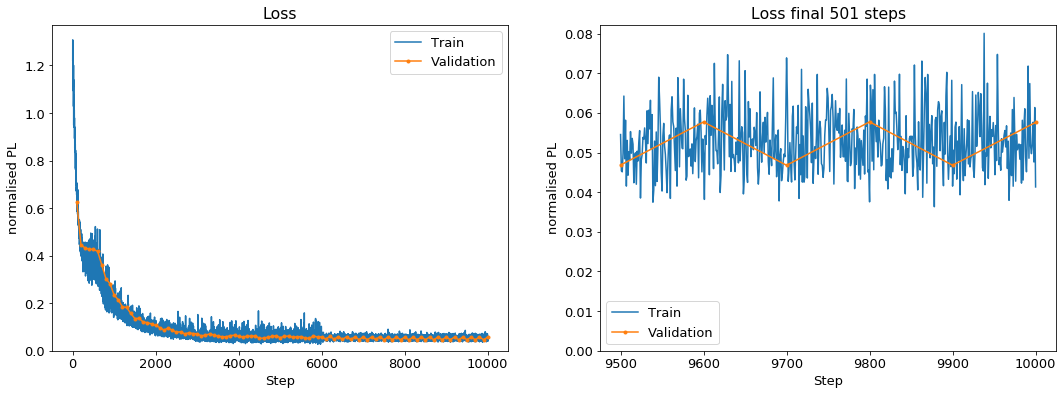

100/100 [==============================] - 2s 22ms/step - loss: 0.0526 - q0_loss: 6.8527e-04 - q1_loss: 0.0018 - q2_loss: 0.0073 - q3_loss: 0.0094 - q4_loss: 0.0119 - q5_loss: 0.0100 - q6_loss: 0.0081 - q7_loss: 0.0024 - q8_loss: 0.0011 - val_loss: 0.0576 - val_q0_loss: 5.3427e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0072 - val_q3_loss: 0.0095 - val_q4_loss: 0.0125 - val_q5_loss: 0.0118 - val_q6_loss: 0.0098 - val_q7_loss: 0.0034 - val_q8_loss: 0.0011
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.11079785990518246, 'WSPL': 0.11079785990518246}


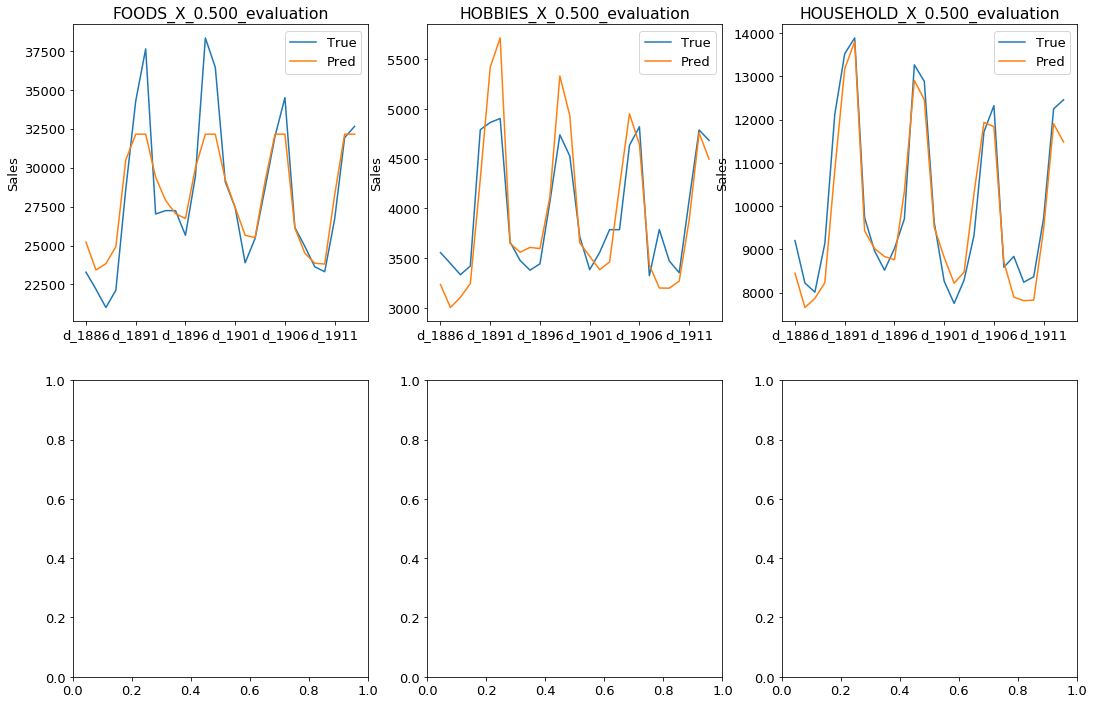

In [19]:
logger_list = []

for lag in [28, 21, 14, 7, 3, 2, 1][::-1]:
    run_dir = model_dir + "/lag{}/".format(lag)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    # track metrics
    part1_metrics = []
    part2_metrics = []
    part3_metrics = []
    
    for level, model in models_base.items():
        if level != 4:
            continue
        # select model
        model = clone_model(models_base[level])
        # train model
        warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                          1e-3, 1e-3, 1e-3] # save part 2
        finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5]
        
        validation_steps = None if level != 12 else 100
        model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
            level, model, warmup_batch_size, finetune_batch_size, ref, calendar, prediction_lag=lag,
            model_dir=run_dir, warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list,
            lgb_prediction=lgb_prediction, lgb_prediction_dir=lgb_prediction_dir, augment_events=augment_events,
            validation_steps=validation_steps
        )

        # save metrics
        logger_list.append(logger); part1_metrics.append(metrics1); 
        part2_metrics.append(metrics2); part3_metrics.append(metrics3)
        for i, m in enumerate([part1_metrics, part2_metrics, part3_metrics]):
            save_object(m, run_dir + "part{}_metrics.pickle".format(i))

## Save results

## Results